In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from matplotlib.pyplot import figure
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport

In [165]:
import warnings
warnings.filterwarnings('ignore')

In [166]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [167]:
train_df.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750


In [168]:
test_df.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income
0,70607,LP002560,1,1,0,1,0,15890,871.075952,188,371,1,1,6000
1,58412,LP001379,1,1,0,0,1,6582,896.718887,17,373,0,1,6000
2,88755,LP002560,0,0,0,0,0,7869,572.900354,17,373,1,1,6000
3,97271,LP002560,1,1,0,0,0,150,0.000000,247,349,1,2,6000
4,70478,LP002231,1,1,0,0,0,8362,0.000000,17,12,1,2,3750


In [169]:
train_df.Loan_Status.value_counts()

Loan_Status
1    4913
0     985
Name: count, dtype: int64

In [170]:
# profile = ProfileReport(train_df)
# profile

Numeric
- Total_Income
- Loan_Amount_Term
- LoanAmount
- CoapplicantIncome
- ApplicantIncome
- ID

Text
- Loan_ID

Categorical
- Loan_Status: Target
- Property_Area
- Credit_History
- Self_Employed
- Education
- Dependents
- Married
- Gender

In [171]:
def plot_value_counts(column_name, df):
    # Calculate value counts
    value_counts = df[column_name].value_counts()

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Define colors
    colors = sns.color_palette("husl", len(value_counts))
    if all(isinstance(x, int) for x in value_counts.index):
        colors[value_counts.index.tolist().index(max(value_counts.index))] = 'red'
    else:
        longest_label = max(value_counts.index, key=len)
        colors[value_counts.index.tolist().index(longest_label)] = 'red'

    # Sort value counts
    sorted_value_counts = value_counts.sort_index()

    # Plot column chart on the first subplot
    sns.countplot(x=column_name, data=df, palette=colors, order=sorted_value_counts.index, ax=ax[0])
    ax[0].set_title(f'Distribution of {column_name.capitalize()}')
    ax[0].set_xlabel(column_name.capitalize())
    ax[0].set_ylabel('Frequency')
    ax[0].tick_params(axis='x', rotation=90)

    # Plot pie chart on the second subplot
    ax[1].pie(sorted_value_counts.values, labels=sorted_value_counts.index, explode=[0.1 if i == sorted_value_counts.idxmax() else 0 for i in sorted_value_counts.index], colors=colors, autopct='%1.1f%%')
    ax[1].set_title(f'Distribution of {column_name.capitalize()}')
    ax[1].axis('equal')

    # Layout so plots do not overlap
    plt.tight_layout()

    plt.show()

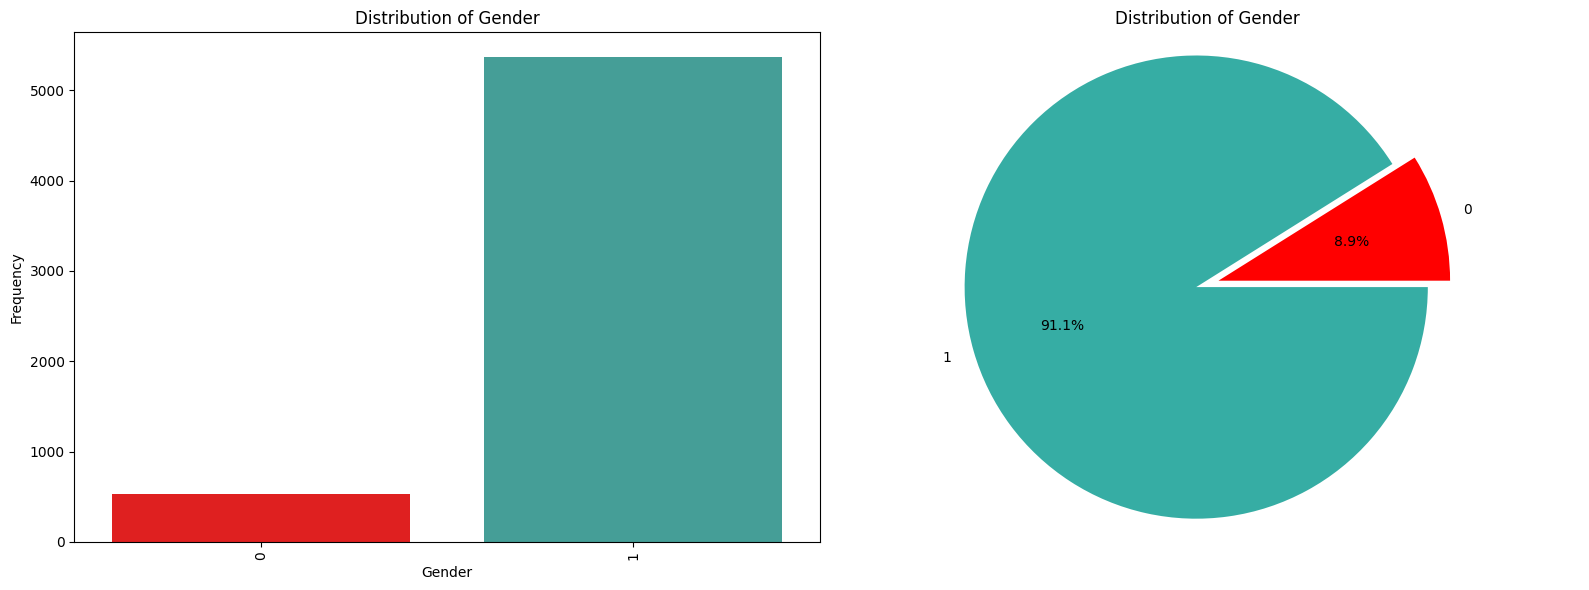

In [172]:
plot_value_counts('Gender', train_df)

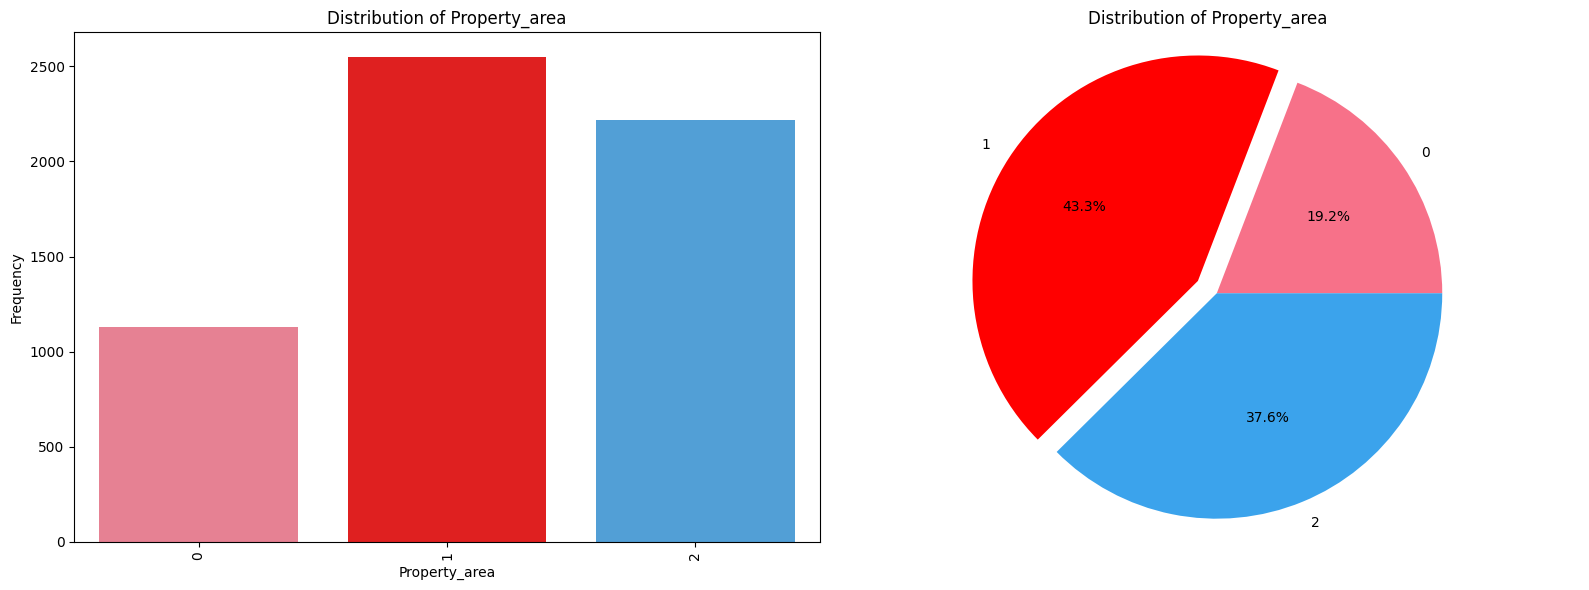

In [173]:
plot_value_counts('Property_Area', train_df)

- 19.2% of people in the rural area are more of credit risk as they may not have enough credit visibility.

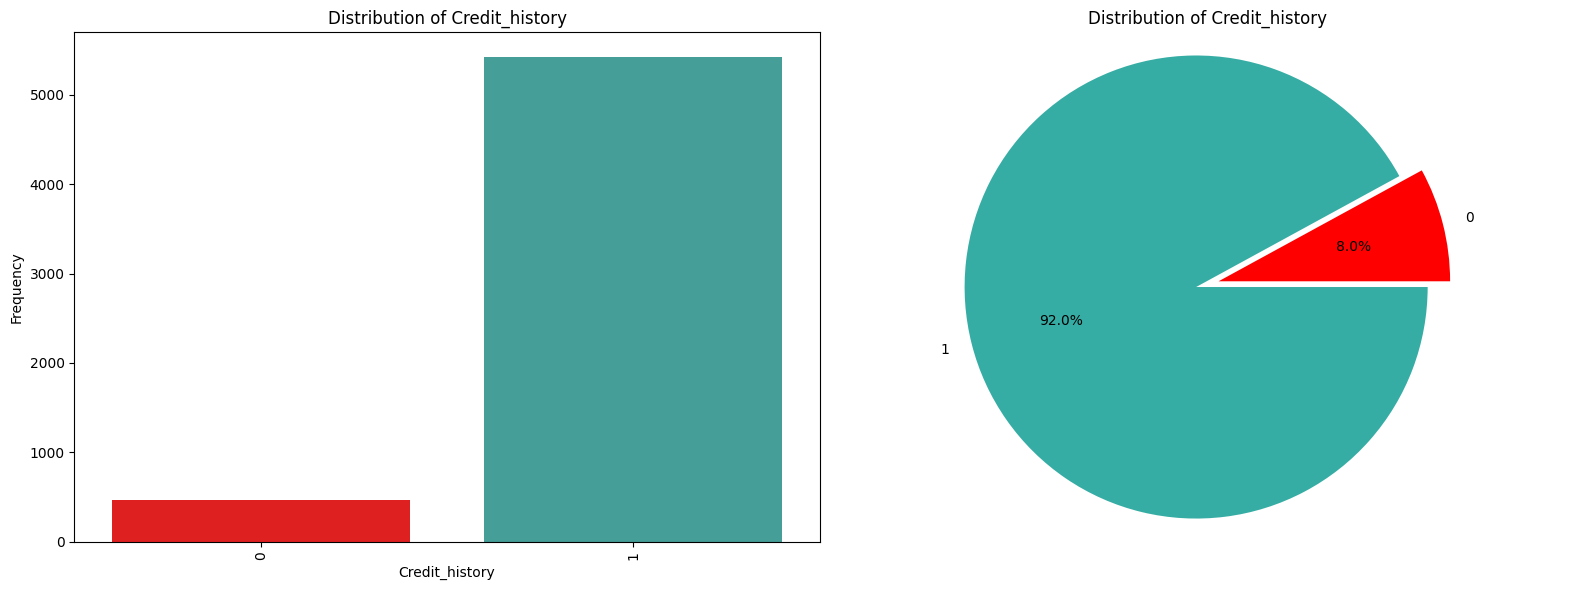

In [174]:
plot_value_counts('Credit_History', train_df)

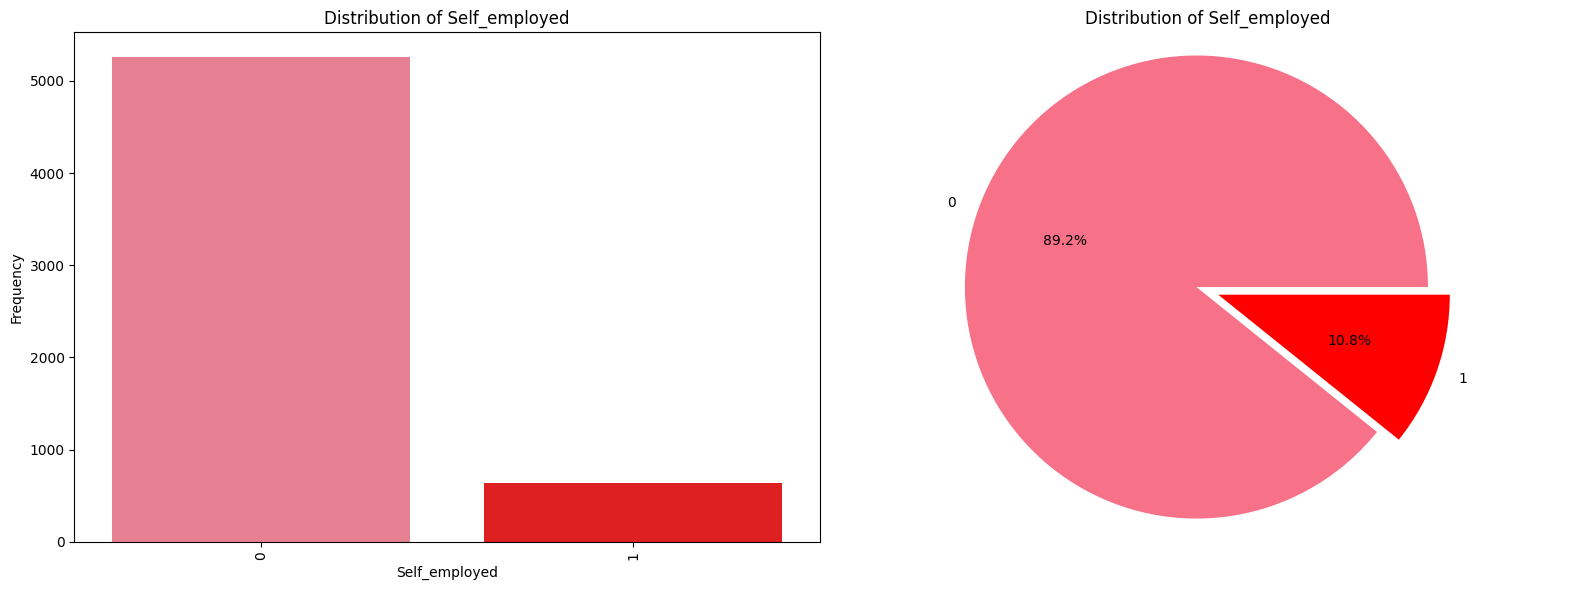

In [175]:
plot_value_counts('Self_Employed', train_df)

- This model needs to understand the risk with the 10.8% sel_employed applicants as their source of income and credit history is more difficulty to ascertain and measure. 

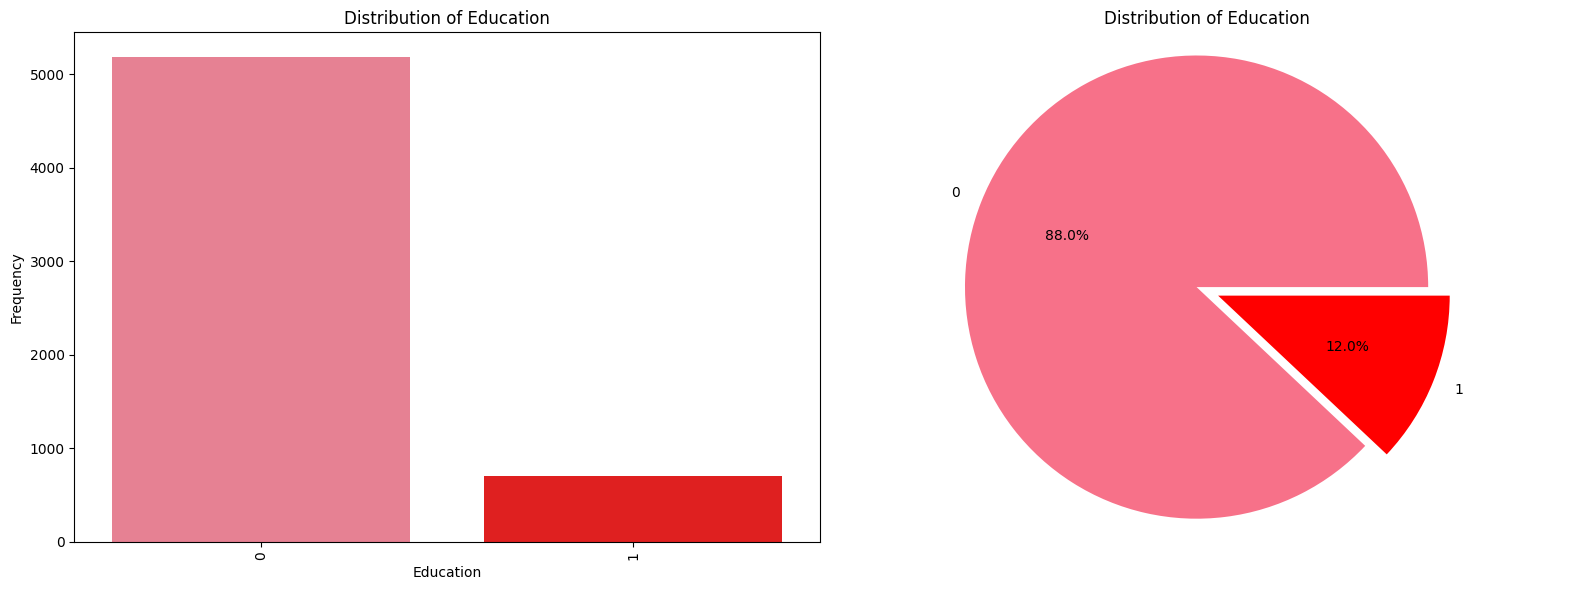

In [176]:
plot_value_counts('Education', train_df)

- Find out the percentage of the educated that has good credit history vs the uneducated vs the loan status

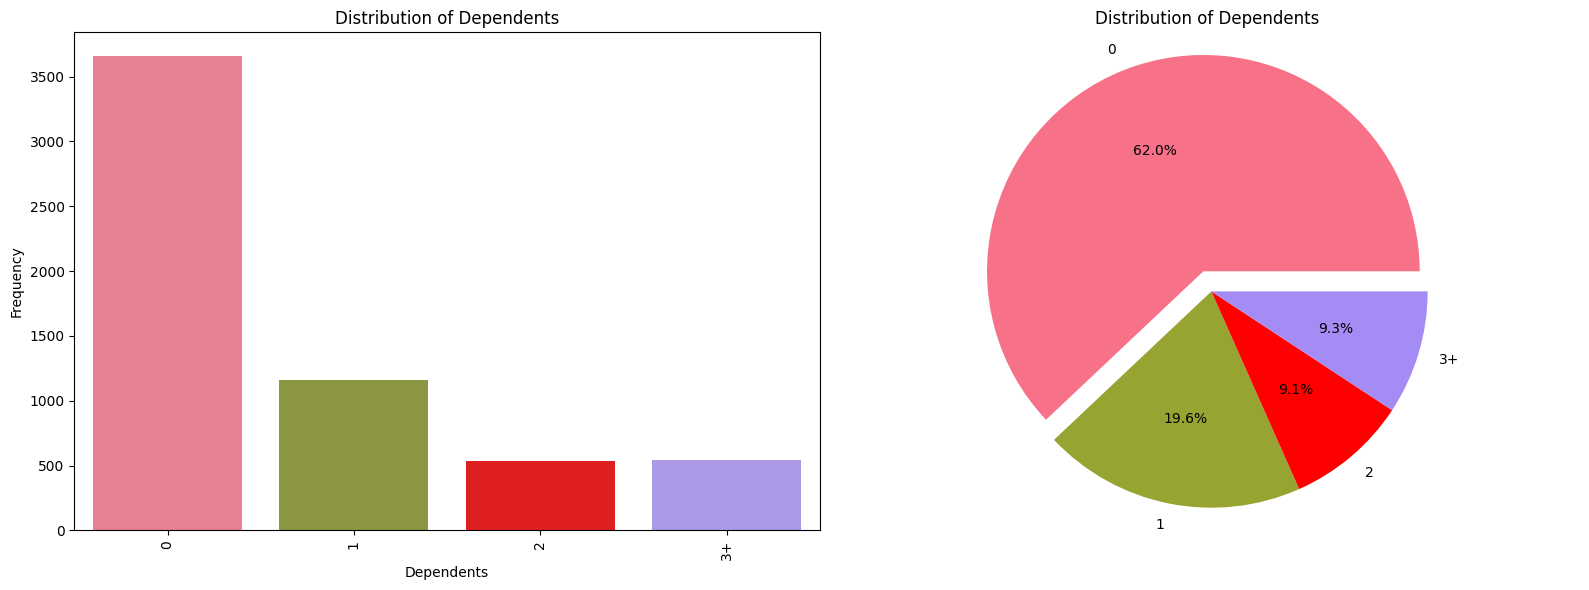

In [177]:
plot_value_counts('Dependents', train_df)

- Find out the percentage of people with 0, 1, 2, 3 dependents good credit history vs loan status.

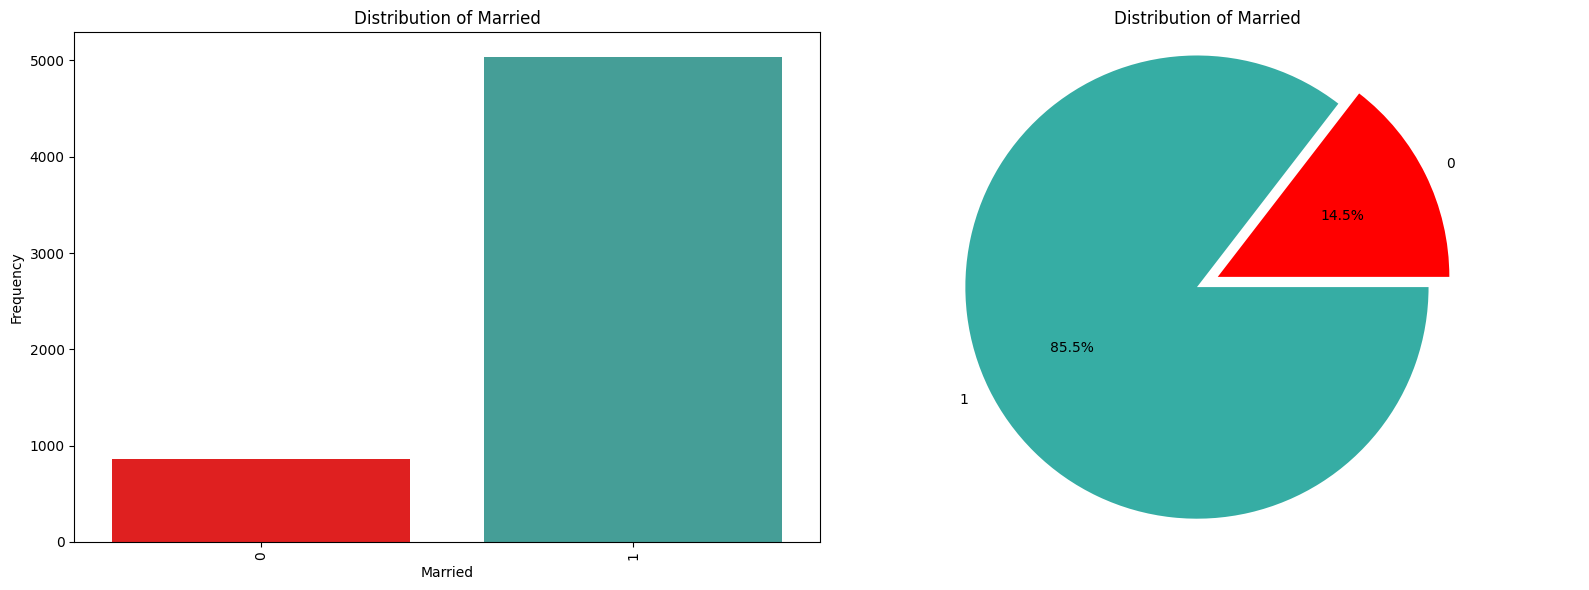

In [178]:
plot_value_counts('Married', train_df)

- Check the relationship unmmarried people, credit history and loan status.

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loan_approval_by_credit_history(df, variable):
    """
    Plot loan approval percentage by a given variable (e.g., Gender) with respect to Credit History.

    Args:
    - df (pd.DataFrame): Dataset containing Loan_Status, Credit_History, and the specified variable.
    - variable (str): Column name of the variable to analyze (e.g., 'Gender').

    Returns:
    - None
    """
    # Filter data for Credit History = 1 and = 0
    credit_history_1 = df[df['Credit_History'] == 1]
    credit_history_0 = df[df['Credit_History'] == 0]

    # Calculate approval percentages for each credit history status
    approval_by_credit_1 = pd.crosstab(credit_history_1[variable], credit_history_1['Loan_Status'], normalize='index') * 100
    approval_by_credit_0 = pd.crosstab(credit_history_0[variable], credit_history_0['Loan_Status'], normalize='index') * 100

    # Rename columns for clarity
    approval_by_credit_1.columns = ['Not Approved', 'Approved']
    approval_by_credit_0.columns = ['Not Approved', 'Approved']

    # Display as a table
    print(f"Loan Approval Percentage by {variable} (Credit History = 1):\n")
    print(approval_by_credit_1.round(2))
    print("\n")
    print(f"Loan Approval Percentage by {variable} (Credit History = 0):\n")
    print(approval_by_credit_0.round(2))
    print("\n")

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Plot Credit History = 1
    approval_by_credit_1.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[0])
    axes[0].set_title(f'Loan Approval Percentage by {variable} (Credit History = 1)')
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel('Percentage')
    axes[0].legend(title='Loan Status')
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))

    # Plot Credit History = 0
    approval_by_credit_0.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[1])
    axes[1].set_title(f'Loan Approval Percentage by {variable} (Credit History = 0)')
    axes[1].set_xlabel(variable)
    axes[1].legend(title='Loan Status')
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))

    # Adjust layout
    plt.tight_layout()
    plt.show()


Loan Approval Percentage by Gender (Credit History = 1):

        Not Approved  Approved
Gender                        
0              16.35     83.65
1              16.72     83.28


Loan Approval Percentage by Gender (Credit History = 0):

        Not Approved  Approved
Gender                        
0              14.29     85.71
1              17.14     82.86




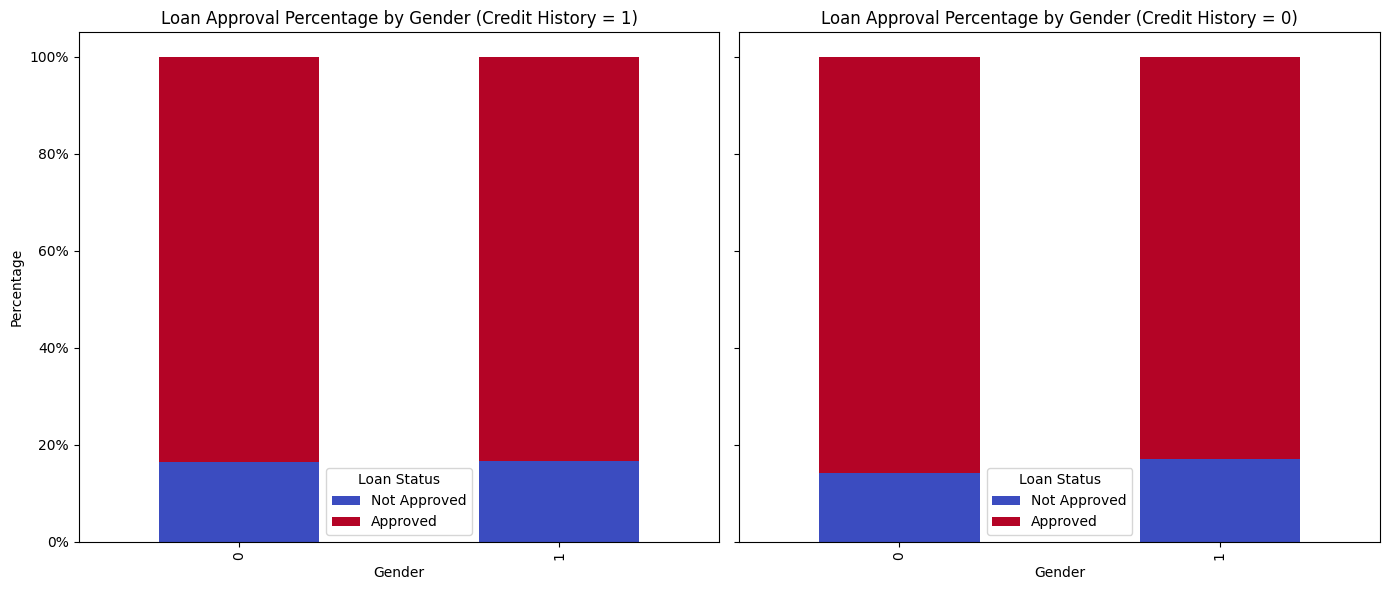

In [180]:
plot_loan_approval_by_credit_history(train_df, 'Gender')

Loan Approval Percentage by Education (Credit History = 1):

           Not Approved  Approved
Education                        
0                 16.55     83.45
1                 17.71     82.29


Loan Approval Percentage by Education (Credit History = 0):

           Not Approved  Approved
Education                        
0                 16.63     83.37
1                 18.52     81.48




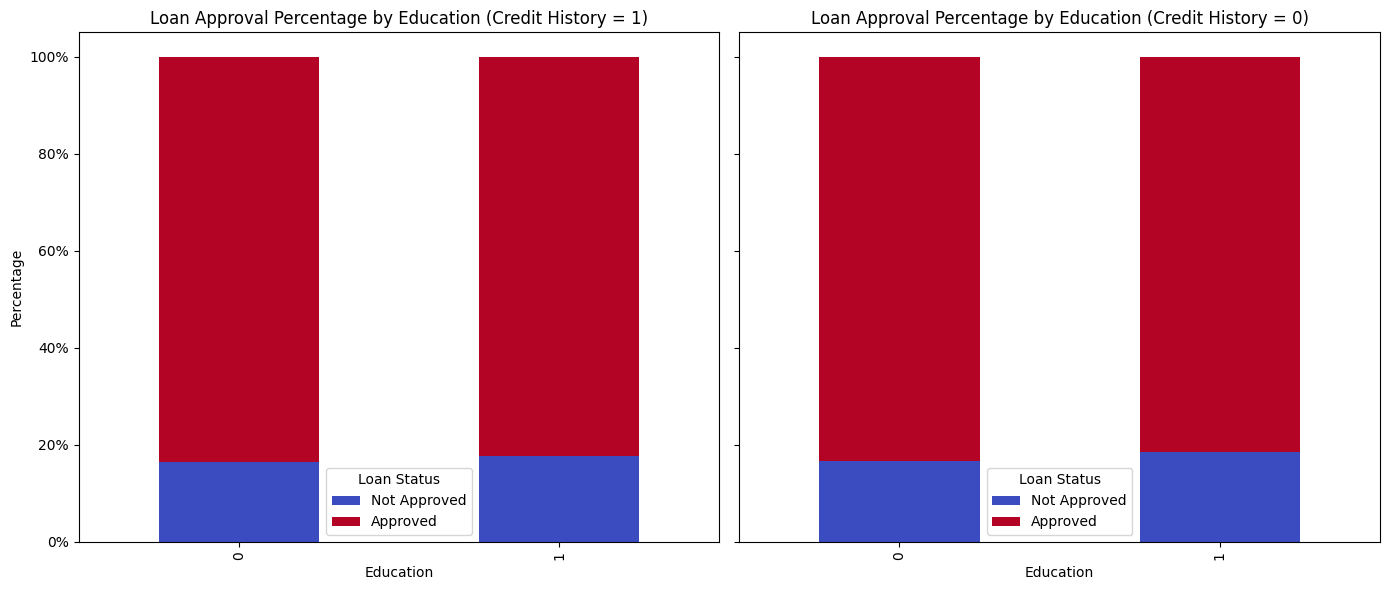

In [181]:
plot_loan_approval_by_credit_history(train_df, 'Education')

Loan Approval Percentage by Married (Credit History = 1):

         Not Approved  Approved
Married                        
0               16.14     83.86
1               16.78     83.22


Loan Approval Percentage by Married (Credit History = 0):

         Not Approved  Approved
Married                        
0               14.08     85.92
1               17.34     82.66




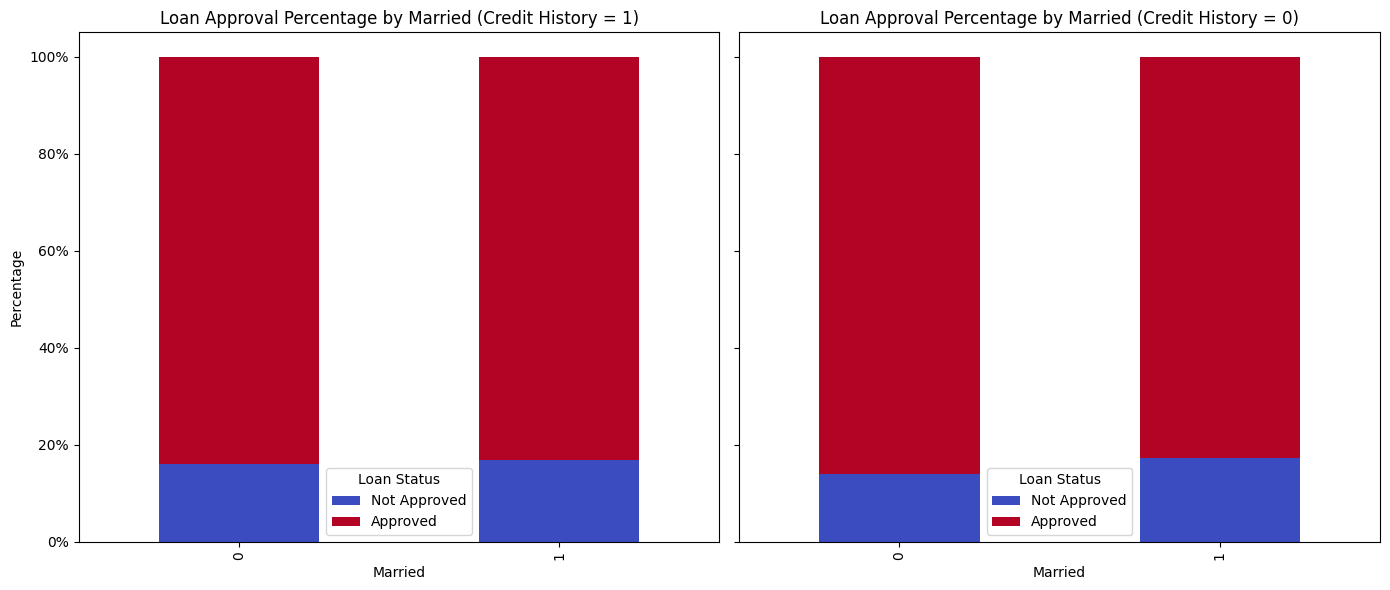

In [182]:
plot_loan_approval_by_credit_history(train_df, 'Married')

Loan Approval Percentage by Property_Area (Credit History = 1):

               Not Approved  Approved
Property_Area                        
0                     18.14     81.86
1                     17.23     82.77
2                     15.32     84.68


Loan Approval Percentage by Property_Area (Credit History = 0):

               Not Approved  Approved
Property_Area                        
0                     19.10     80.90
1                     15.00     85.00
2                     17.78     82.22




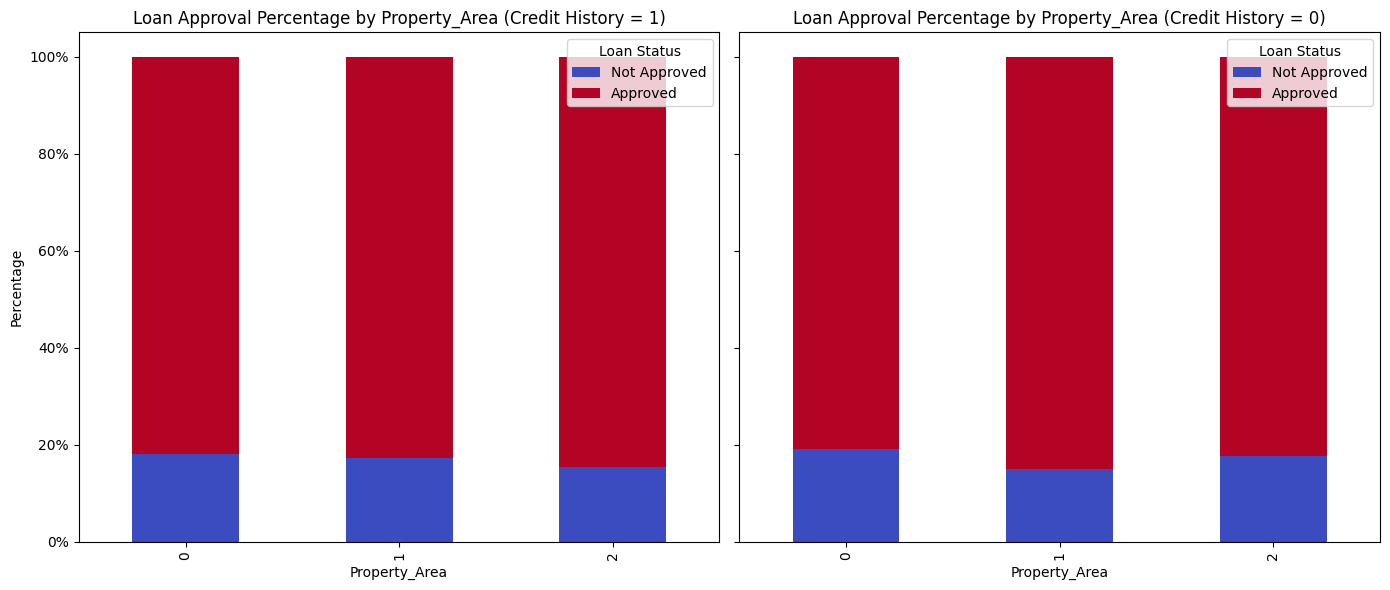

In [183]:
plot_loan_approval_by_credit_history(train_df, 'Property_Area')


Loan Approval Percentage by Dependents (Credit History = 1):

            Not Approved  Approved
Dependents                        
0                  15.95     84.05
1                  17.60     82.40
2                  17.29     82.71
3+                 19.16     80.84


Loan Approval Percentage by Dependents (Credit History = 0):

            Not Approved  Approved
Dependents                        
0                  17.19     82.81
1                  16.87     83.13
2                  21.43     78.57
3+                  8.89     91.11




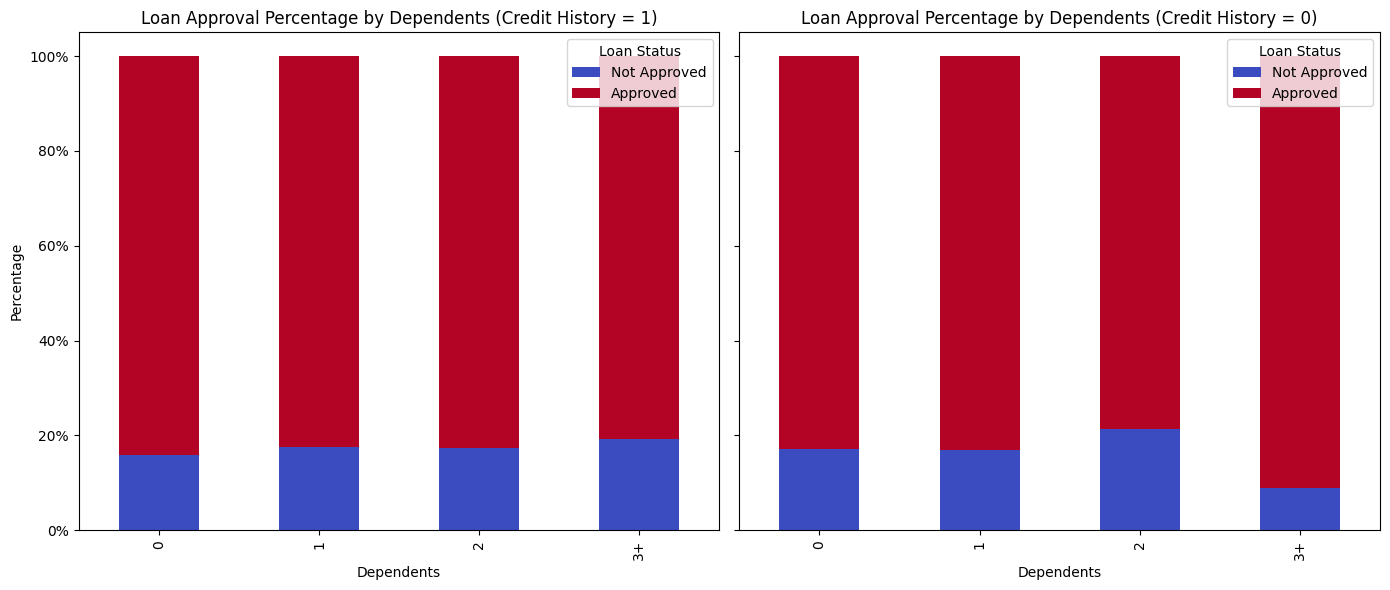

In [184]:
plot_loan_approval_by_credit_history(train_df, 'Dependents')

Loan Approval Percentage by Self_Employed (Credit History = 1):

               Not Approved  Approved
Self_Employed                        
0                     16.79     83.21
1                     15.84     84.16


Loan Approval Percentage by Self_Employed (Credit History = 0):

               Not Approved  Approved
Self_Employed                        
0                     16.63     83.37
1                     18.75     81.25




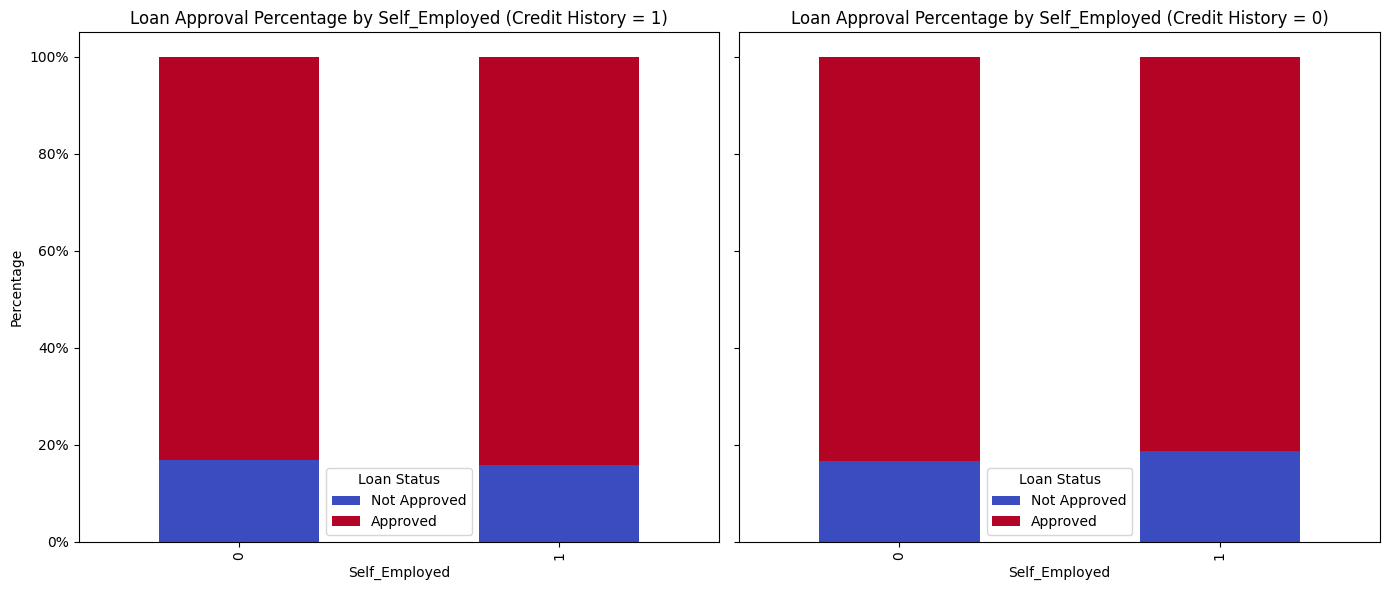

In [185]:
plot_loan_approval_by_credit_history(train_df, 'Self_Employed')

- Lets BIN the loan term and still apply the credit_history funtion

In [186]:
train_df['Loan_Term_Category'] = pd.cut(train_df['Loan_Amount_Term'], 
                                  bins=[0, 100, 300, 500], 
                                  labels=['Short-term', 'Mid-term', 'Long-term'], 
                                  include_lowest=True)

test_df['Loan_Term_Category'] = pd.cut(test_df['Loan_Amount_Term'], 
                                  bins=[0, 100, 300, 500], 
                                  labels=['Short-term', 'Mid-term', 'Long-term'], 
                                  include_lowest=True)

In [187]:
train_df.Loan_Term_Category.value_counts()

Loan_Term_Category
Long-term     5665
Mid-term       153
Short-term      80
Name: count, dtype: int64

Loan Approval Percentage by Loan_Term_Category (Credit History = 1):

                    Not Approved  Approved
Loan_Term_Category                        
Short-term                 15.28     84.72
Mid-term                   13.14     86.86
Long-term                  16.80     83.20


Loan Approval Percentage by Loan_Term_Category (Credit History = 0):

                    Not Approved  Approved
Loan_Term_Category                        
Short-term                  50.0      50.0
Mid-term                    12.5      87.5
Long-term                   16.4      83.6




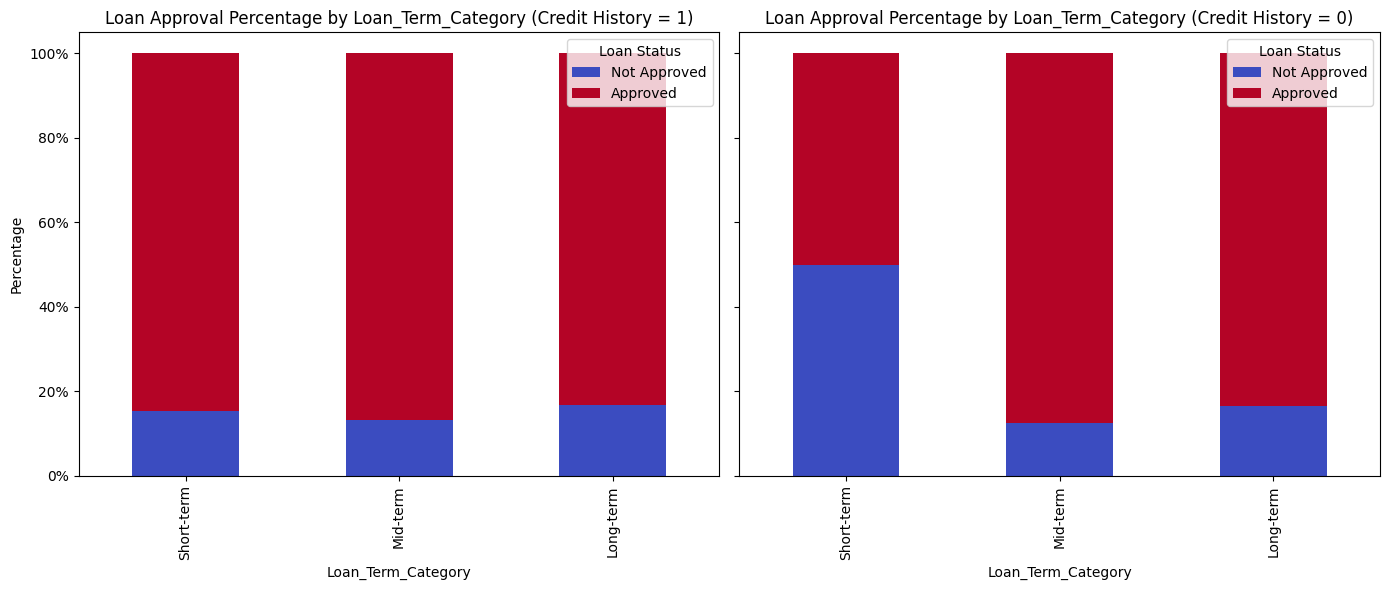

In [188]:
plot_loan_approval_by_credit_history(train_df, 'Loan_Term_Category')

In [189]:
train_df['Income_Category'] = pd.cut(train_df['ApplicantIncome'], 
                               bins=[0, 10000, 65000, 81000], 
                               labels=['Low', 'Mid', 'High'], 
                               include_lowest=True)

test_df['Income_Category'] = pd.cut(test_df['ApplicantIncome'], 
                               bins=[0, 10000, 65000, 81000], 
                               labels=['Low', 'Mid', 'High'], 
                               include_lowest=True)

In [190]:
train_df.Income_Category.value_counts()

Income_Category
Low     4789
Mid     1063
High      46
Name: count, dtype: int64

Loan Approval Percentage by Income_Category (Credit History = 1):

                 Not Approved  Approved
Income_Category                        
Low                     16.60     83.40
Mid                     16.77     83.23
High                    23.81     76.19


Loan Approval Percentage by Income_Category (Credit History = 0):

                 Not Approved  Approved
Income_Category                        
Low                     16.84     83.16
Mid                     15.19     84.81
High                    50.00     50.00




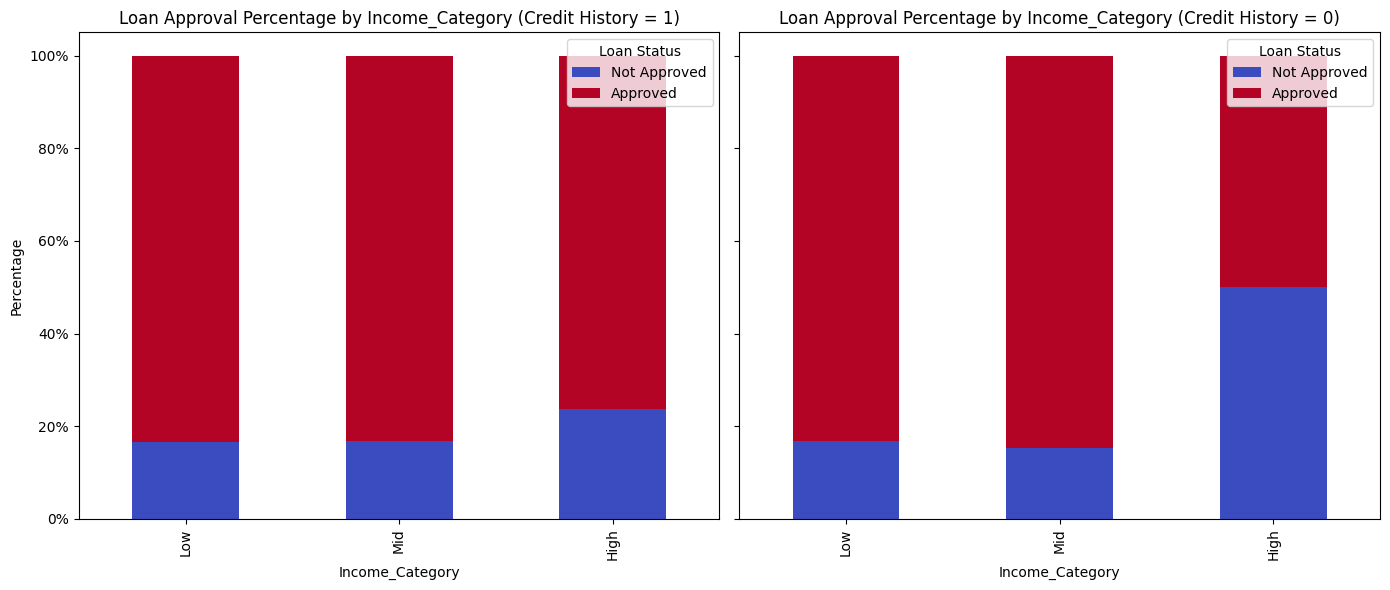

In [191]:
plot_loan_approval_by_credit_history(train_df, 'Income_Category')

In [192]:
zero_coincome_low_appincome_declined = len(train_df[(train_df['CoapplicantIncome'] == 0) & 
                                              (train_df['Income_Category'] == 'Low') & 
                                              (train_df['Loan_Status'] == 0)])

total_zero_coincome_low_appincome = len(train_df[(train_df['CoapplicantIncome'] == 0) & 
                                           (train_df['Income_Category'] == 'Low')])

percentage_declined = (zero_coincome_low_appincome_declined / total_zero_coincome_low_appincome) * 100

print(f'Percentage of loans declined for co-applicants with zero income and applicants with low income: {percentage_declined:.2f}%')


Percentage of loans declined for co-applicants with zero income and applicants with low income: 16.31%


- 16.31% of 4789 is 781 loan declines, 80% of total loan decline of 985. So this category holds 80% of loan declines. 

In [193]:
# Generate categorical feature for zero co-applicant income and low applicant income
train_df['Zero_Coincome_Low_Appincome'] = ((train_df['CoapplicantIncome'] == 0) & 
                                     (train_df['Income_Category'] == 'Low')).astype(int)

# Generate categorical feature for zero co-applicant income and low applicant income
test_df['Zero_Coincome_Low_Appincome'] = ((test_df['CoapplicantIncome'] == 0) & 
                                     (test_df['Income_Category'] == 'Low')).astype(int)


In [194]:
train_df.Zero_Coincome_Low_Appincome.value_counts()

Zero_Coincome_Low_Appincome
0    3654
1    2244
Name: count, dtype: int64

Loan Approval Percentage by Zero_Coincome_Low_Appincome (Credit History = 1):

                             Not Approved  Approved
Zero_Coincome_Low_Appincome                        
0                                   16.87     83.13
1                                   16.39     83.61


Loan Approval Percentage by Zero_Coincome_Low_Appincome (Credit History = 0):

                             Not Approved  Approved
Zero_Coincome_Low_Appincome                        
0                                   17.87     82.13
1                                   15.53     84.47




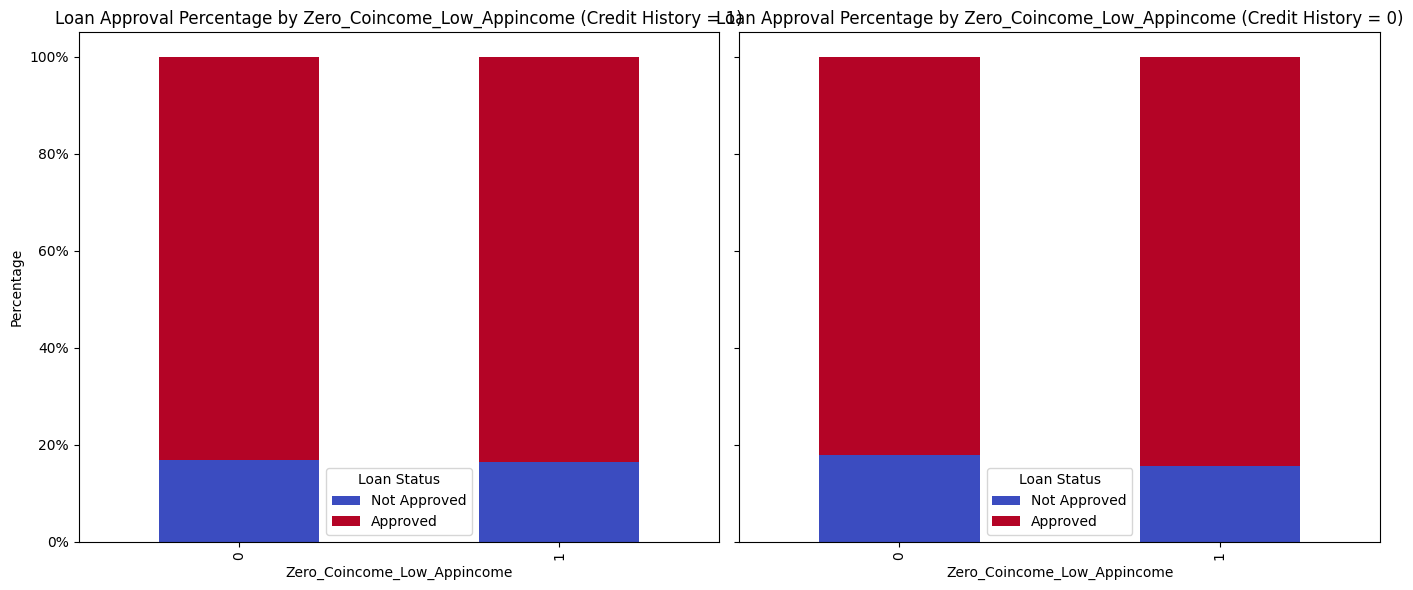

In [195]:
plot_loan_approval_by_credit_history(train_df, 'Zero_Coincome_Low_Appincome')

In [196]:
# Assume 'LoanAmount' is the column name
train_df['Loan_Size_Category'] = pd.cut(train_df['LoanAmount'], 
                                  bins=[17, 150, 300, 700], 
                                  labels=['Small', 'Mid', 'Large'], 
                                  include_lowest=True)

# Assume 'LoanAmount' is the column name
test_df['Loan_Size_Category'] = pd.cut(test_df['LoanAmount'], 
                                  bins=[17, 150, 300, 700], 
                                  labels=['Small', 'Mid', 'Large'], 
                                  include_lowest=True)

Loan Approval Percentage by Loan_Size_Category (Credit History = 1):

                    Not Approved  Approved
Loan_Size_Category                        
Small                      16.88     83.12
Mid                        16.61     83.39
Large                      11.01     88.99


Loan Approval Percentage by Loan_Size_Category (Credit History = 0):

                    Not Approved  Approved
Loan_Size_Category                        
Small                      17.23     82.77
Mid                        16.79     83.21
Large                       7.69     92.31




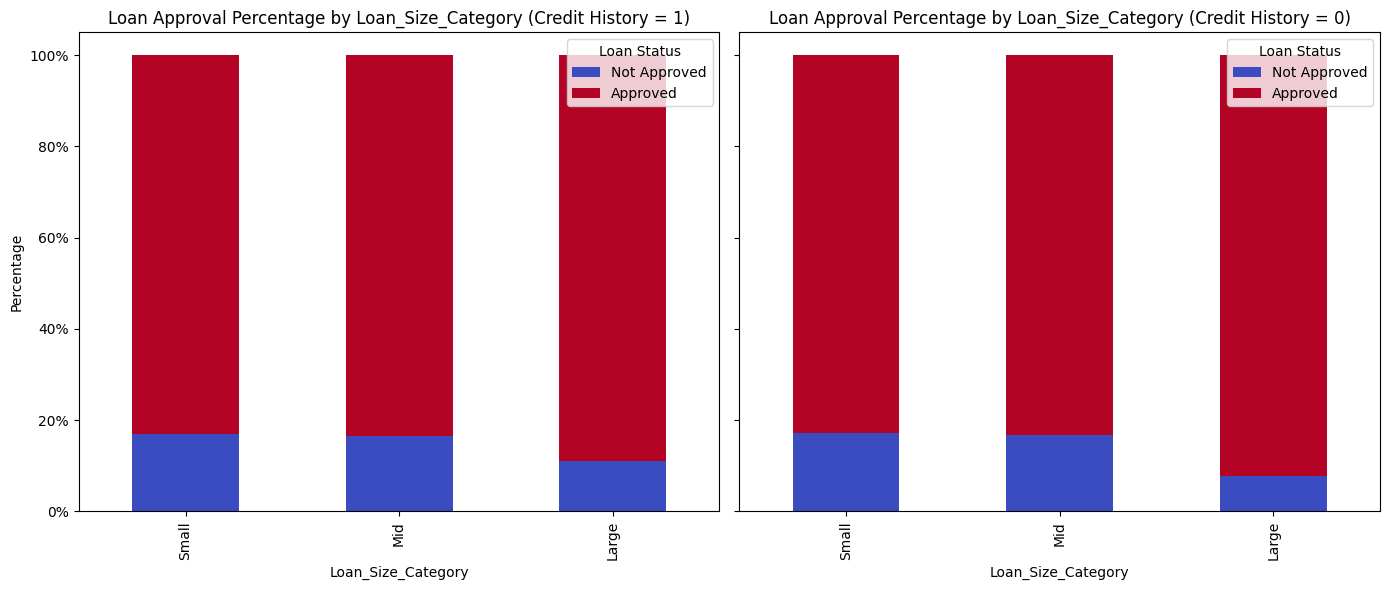

In [197]:
plot_loan_approval_by_credit_history(train_df, 'Loan_Size_Category')

Insights summary

1. women(0) with credit history of 1, have 83.65 % positive approval rate.
2. Women with 0 credit history score has 85.71% approval rate, a far more rate than men
3. Educated applicants with credit history score of 1 have 82.29% approval rate as against 83.45 % for uneducated. Uneducated business men in Nigeria tends to be more trusted. 
4. Uneducated with 0 credit history has 83.37% approval rate against 81.48% for educated
5. Married applicants with credit history of 1 has 83.22% as against unmarried which has more approval rate of 83.86.
6. Married applicants with with 0 credit history has 82.66% approval rate against 85.92% approval for the unmarried. 
7. Applicants with property in urban area with credit history of 1 have 84.68% against 82.77% for applicants with property in suburban and 81.86% in rural.
8. Applicants with credit history 0 and with property in suburban has 85% approval against 82.22 urban and 80.90% in rural.
9. Applicants with credit history = 1 with 0 dependents have 84.05% approval against 82.40%, 82.71% and 80.84% for 1,2, 3+ dependents respectively.
10. People with 3+ dependents and credit history of 0 has a strange approval rate of 91.11%, followed  1 dependents with 83.13%, then 0 dependents at 82.81%, 2 dependents at 78.57% approval rates.
11. Applicants with credit history of 1 who are self employed stand a high of approval with 84.16% rate against 83.21 for those who are not.
12. Applicants with credit history of 0 who are self employed has less approval rate at 81.25% against 83.37% for those who not self employed.
13. Applicants with credit history of 1 asking for short term loan has hight chance of approval at 83.87% approval rate against those asking for mid term: 80.56% and longterm: 83.32.
14. Applicants with 0 credit history asking for midterm loan had 100% loan approval while those with midterm loan ask has rejection rate of 66.67%, with long-term loan ask with 83.62% approval rate.
15. 16.31% of 4789 is 781 loan declined, 80% of total loan decline of 985. So this category holds 80% of loan declines for applicants with 0 coapplicant income and low applicant income.

In [198]:
#join the test and trainset to ensure uniform preprocessing
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y = train_df['Loan_Status']
complete_data = pd.concat((train_df, test_df)).reset_index(drop=True)
complete_data.drop(['Loan_Status'], axis=1, inplace=True)
print("all_data size is : {}".format(complete_data.shape))

all_data size is : (8426, 18)


In [199]:
complete_data.LoanAmount = complete_data.LoanAmount * 1000

### data engneer to build first model

In [200]:
def feature_engineering(data):
    # # Combined Gender and Marital Status feature
    # train_df['Gender_Married'] = train_df['Gender'] + "_" + train_df['Married']
    
    # Bin Dependents into categories
    # train_df['Dependents_Cat'] = train_df['Dependents'].replace({'3+': '3 or more'}).fillna('0')
    
    # Financial load per household member
    data['Income_Per_Dependent'] = data['ApplicantIncome'] / (data['Dependents'].replace('3+', 3).astype(int)).replace(0, 1)
    
    # Interaction of Education with Applicant Income
    #data['Edu_Income'] = np.where(data['Education'] == 1, data['ApplicantIncome'] * 1.1, data['ApplicantIncome'] * 0.9)

    # Self-employed stability indicator (combined with credit history and loan term)
    data['Income_Stability'] = np.where((data['Self_Employed'] == 1 ) & (data['Credit_History'] == 1), 
                                            data['ApplicantIncome'] * 1.05, data['ApplicantIncome'] * 0.95)

    # Total income (applicant + coapplicant)
    # train_df['TotalIncome'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']

    # Loan affordability ratios
    #data['Loan_Income_Ratio'] = data['LoanAmount'] / data['Total_Income'] #.replace(0, 1)  # Avoid division by zero
    data['Income_Loan_Ratio'] = data['Total_Income'] / data['LoanAmount'] #.replace(0, 1)
    # Interaction between Credit_History and TotalIncome
    #data['Credit_TotalIncome'] = np.where(data['Credit_History'] == 1, 
                                          #data['Total_Income'] * 1.1, data['Total_Income'] * 0.9)
    return data

data_engr = feature_engineering(complete_data)

In [202]:
def scale(data):
    # # Combined Gender and Marital Status feature
    # train_df['Gender_Married'] = train_df['Gender'] + "_" + train_df['Married']
    
    # Bin Dependents into categories
    # train_df['Dependents_Cat'] = train_df['Dependents'].replace({'3+': '3 or more'}).fillna('0')
    
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate the scaler
    scaler = MinMaxScaler()
    # Apply Min-Max scaling to the specified columns and replace them in the DataFrame
    data[['LoanAmount', 'Total_Income', 'ApplicantIncome', 
          'CoapplicantIncome', 'Income_Per_Dependent', 'Income_Stability', 
          'Income_Loan_Ratio']] = scaler.fit_transform(
    data[['LoanAmount', 'Total_Income', 'ApplicantIncome', 
          'CoapplicantIncome', 'Income_Per_Dependent', 'Income_Stability', 
          'Income_Loan_Ratio']]
)

    # Monthly installment and income-to-term ratio
    #data['Monthly_Installment'] = data['LoanAmount'] / data['Loan_Amount_Term']#.replace(0, 1)  # Avoid division by zero
    #data['Income_to_Term_Ratio'] = data['Total_Income'] / data['Loan_Amount_Term']#.replace(0, 1)
    return data

# Apply the feature engineering function to your training dataset
data_engr = scale(complete_data)


In [203]:
def dummy(data):
    # Property area dummies
    data = pd.get_dummies(data, columns=['Property_Area'], prefix='Area')
    #data = pd.get_dummies(data, columns=['Credit_History_Flag'], prefix='Credit')
    data = pd.get_dummies(data, columns=['Loan_Term_Category'], prefix='Loan_term')
    data = pd.get_dummies(data, columns=['Income_Category'], prefix='Income')
    data = pd.get_dummies(data, columns=['Loan_Size_Category'], prefix='Loan_size')
    data = pd.get_dummies(data, columns=['Dependents'], prefix='Dependents')

    # Interaction between Credit_History and Monthly_Installment
    #data['Credit_Installment_Ratio'] = np.where(data['Credit_History'] == 1, 
    #                                                data['Monthly_Installment'] * 0.95, data['Monthly_Installment'] * 1.1)
    columns_to_drop = ['Loan_ID', 'Self_Employed', 'ApplicantIncome', 'Dependents','Loan_Amount_Term', 
    'Credit_History', 'Property_Area', 'Total_Income', 
    'Loan_Term_Category', 'Income_Category', 
    'Loan_Size_Category']

    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)
    
    return data

# Apply the feature engineering function to your training dataset
data_engr = dummy(complete_data)


In [204]:
train_data = data_engr[:ntrain]
test_data = data_engr[ntrain:]

In [205]:
#method to evaluate and train randomforest
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    rs=123
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    submit = model.predict(test_data.drop(['ID'], axis=1))

    # Create submission DataFrame and save to CSV
    submit_df = pd.DataFrame({'id': test_data['ID'], 'Loan_Status': submit})
    submit_df.to_csv('submit1.csv', index=False)
    return yp, model

In [206]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Method to resample original dataset
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state=123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)  # Add this line
    return X_smo, y_smo, X_under, y_under  # Update return statement

def split_data(df, target):
    return train_test_split(df, target, test_size=0.25, stratify=target, random_state=123)  # Use 'target' instead of 'y'

# Split the training and testing dataset
x_train, x_test, y_train, y_test = split_data(train_data.drop(['ID'], axis=1), y)

# Resample the training data
X_smo, y_smo, X_under, y_under = resample(x_train, y_train)

In [207]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier

# def grid_search_tuning(X_smo, y_smo):
#     # Define parameter grids for each model
#     param_grids = {
#         'xgb': {
#             'n_estimators': [100, 200],
#             'max_depth': [3, 5, 7],
#             'learning_rate': [0.01, 0.1, 0.2],
#             'subsample': [0.8, 1],
#             'colsample_bytree': [0.8, 1]
#         },
#         'rf': {
#             'n_estimators': [100, 200],
#             'max_depth': [None, 10, 20],
#             'min_samples_split': [2, 5],
#             'min_samples_leaf': [1, 2],
#             'max_features': ['sqrt', 'log2']
#         },
#         'cat': {
#             'iterations': [100, 200],
#             'depth': [4, 6, 8],
#             'learning_rate': [0.01, 0.1, 0.2],
#             'l2_leaf_reg': [3, 5, 7]
#         }
#     }

#     # Models
#     models = {
#         'xgb': XGBClassifier(),
#         'rf': RandomForestClassifier(),
#         'cat': CatBoostClassifier(verbose=0)
#     }

#     best_params = {}

#     for model_name, model in models.items():
#         grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], 
#                                    scoring='f1', cv=4, n_jobs=-1, verbose=1)
#         grid_search.fit(X_smo, y_smo)
#         best_params[model_name] = grid_search.best_params_

#     return best_params


In [208]:
# best_param = grid_search_tuning(X_under, y_under)

In [209]:
# best_param

In [210]:
best_params = {
    'xgb': {'colsample_bytree': 0.8,
            'learning_rate': 0.01,
            'max_depth': 5,
            'n_estimators': 100,
            'subsample': 1},  # Assigns weight ratio (4:1) for XGBoost
     'rf': {'max_depth': 10,
              'max_features': 'log2',
              'min_samples_leaf': 1,
              'min_samples_split': 2,
              'n_estimators': 100}, 
      'cat': {'depth': 4, 'iterations': 100,
                'l2_leaf_reg': 7,'learning_rate': 0.2} # Specifies class weights for CatBoost as a list
    }

In [211]:
def train_xgboost(X_smo, y_smo, x_test, y_test, best_params):
    xgb_params = best_params['xgb']  # Use only XGBoost-specific parameters
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_smo, y_smo)
    y_pred = xgb.predict(x_test)
    
    # Evaluation metrics
    print("XGBoost Evaluation:")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - XGBoost")
    plt.show()
    return xgb

XGBoost Evaluation:
F1 Score: 0.6705
AUC: 0.4799
Precision: 0.8235
Recall: 0.5655


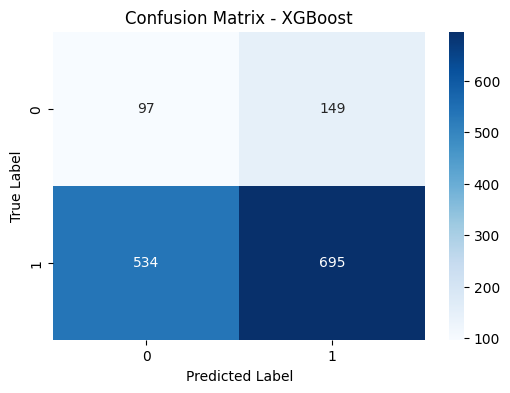

In [212]:
xgb_model = train_xgboost(X_smo, y_smo, x_test, y_test, best_params)

In [213]:
def train_random_forest(X_train, y_train, X_test, y_test, best_params):
    rf_params = best_params['rf']  # Use only RandomForest-specific parameters
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Evaluation metrics
    print("Random Forest Evaluation:")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()
    return rf

Random Forest Evaluation:
F1 Score: 0.6928
AUC: 0.4815
Precision: 0.8247
Recall: 0.5972


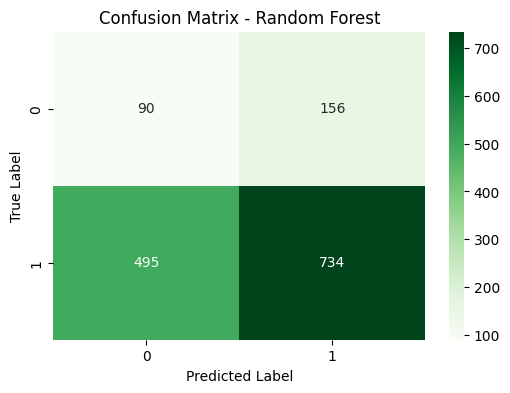

In [214]:
rf_model = train_random_forest(X_smo, y_smo, x_test, y_test, best_params)

In [215]:
from catboost import CatBoostClassifier
def train_catboost(X_train, y_train, X_test, y_test, best_params):
    cat_params = best_params['cat']  # Use only CatBoost-specific parameters
    cat = CatBoostClassifier(**cat_params, verbose=0)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)
    
    # Evaluation metrics
    print("CatBoost Evaluation:")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - CatBoost")
    plt.show()
    return cat

CatBoost Evaluation:
F1 Score: 0.7398
AUC: 0.4743
Precision: 0.8227
Recall: 0.6721


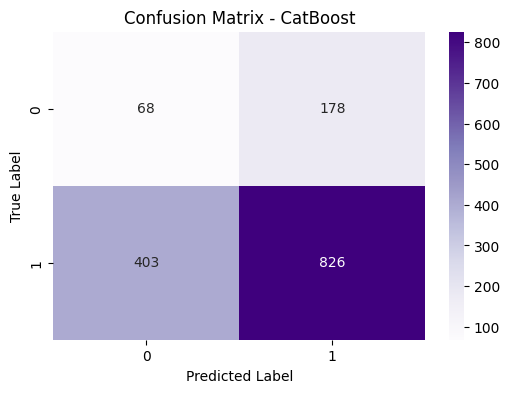

In [216]:
cat_model = train_catboost(X_smo, y_smo, x_test, y_test, best_params)

Voting Classifier Evaluation:
F1 Score: 0.7185
AUC: 0.4844
Precision: 0.8265
Recall: 0.6355


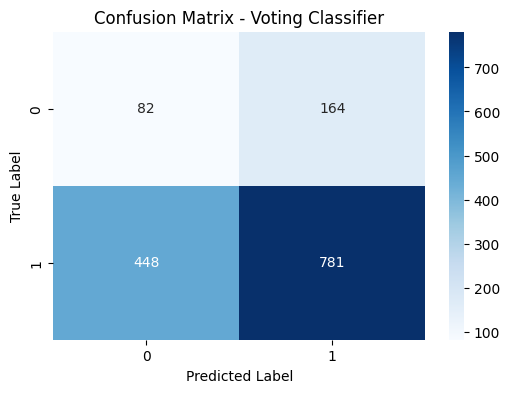

In [217]:
from sklearn.ensemble import VotingClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# Train individual models
# xgb_model = train_xgboost(X_smo, y_smo, x_test, y_test, best_params)
# rf_model = train_random_forest(X_smo, y_smo, x_test, y_test, best_params)
# cat_model = train_catboost(X_smo, y_smo, x_test, y_test, best_params)

# Create a voting classifier with hard voting
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('cat', cat_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_smo, y_smo)

# Evaluate the voting classifier
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    print("Voting Classifier Evaluation:")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Voting Classifier")
    plt.show()

# Evaluate the voting classifier
evaluate_model(voting_clf, x_test, y_test)

In [218]:
def save_predictions_to_csv(model, test_data, filename):
    predictions = model.predict(test_data.drop(['ID'], axis= 1))
    output = pd.DataFrame({'ID': test_data['ID'], 'Loan_Status': predictions})
    output.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [220]:
save_predictions_to_csv(voting_clf, test_data,'vot_model_pred56.csv')

Predictions saved to vot_model_pred56.csv


In [221]:
x_test.head()

,Gender,Married,Education,CoapplicantIncome,LoanAmount,Zero_Coincome_Low_Appincome,Income_Per_Dependent,Income_Stability,Income_Loan_Ratio,Area_0,...,Income_Low,Income_Mid,Income_High,Loan_size_Small,Loan_size_Mid,Loan_size_Large,Dependents_0,Dependents_1,Dependents_2,Dependents_3+
4868,1,0,0,0.000000,0.000000,1,0.001235,0.000177,0.194567,False,...,True,False,False,True,False,False,True,False,False,False
1409,1,1,0,0.098547,0.039531,0,0.089487,0.079932,0.072366,False,...,True,False,False,True,False,False,True,False,False,False
3721,1,0,0,0.000000,0.317716,1,0.089438,0.079887,0.018574,False,...,True,False,False,False,True,False,True,False,False,False
1498,1,1,0,0.000000,0.226940,1,0.001235,0.000000,0.026918,False,...,True,False,False,False,True,False,True,False,False,False
4436,1,1,0,0.180565,0.351391,0,0.028499,0.024693,0.016502,False,...,True,False,False,False,True,False,False,True,False,False
